# Scatter Plots - FUR

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from andbro__store_as_pickle import __store_as_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [8]:
# ---------------------------------------

config = {}

# long data january - september
config['project'] = "2"

config['codes'] = {"":"B", "2":"L"}

# ---------------------------------------
c = config['codes'][config['project']]

name01 = f"FFBI_{c}DO"
name02 = f"FFBI_{c}DF"

name1 = "FUR_BHN"
name2 = "FUR_BHE"
name3 = "FUR_BHZ"

t1, t2 = "2024-09-01", "2024-09-20"

# specify paths
config['path_to_figs'] = data_path+f"LNM2/figures{config['project']}/scatter/"

config['path_to_data'] = data_path+f"LNM2/data{config['project']}/"


## Methods

In [9]:
from functions.get_octave_bands import __get_octave_bands
from functions.quantile_regression import __quantile_regression
from functions.compute_odr import __compute_orthogonal_distance_regression

## Load Data

In [10]:
dat01 = pd.read_pickle(config['path_to_data']+name01+".pkl")
dat02 = pd.read_pickle(config['path_to_data']+name02+".pkl")

dat1 = pd.read_pickle(config['path_to_data']+name1+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")
dat3 = pd.read_pickle(config['path_to_data']+name3+".pkl")

coh11 = pd.read_pickle(config['path_to_data']+name01+"_"+name1+"_coherence.pkl")
coh12 = pd.read_pickle(config['path_to_data']+name01+"_"+name2+"_coherence.pkl")
coh13 = pd.read_pickle(config['path_to_data']+name01+"_"+name3+"_coherence.pkl")

coh21 = pd.read_pickle(config['path_to_data']+name02+"_"+name1+"_coherence.pkl")
coh22 = pd.read_pickle(config['path_to_data']+name02+"_"+name2+"_coherence.pkl")
coh23 = pd.read_pickle(config['path_to_data']+name02+"_"+name3+"_coherence.pkl")


## Plot all 

-17.468935233211937 -17.598998206481035 -20.364149244430973


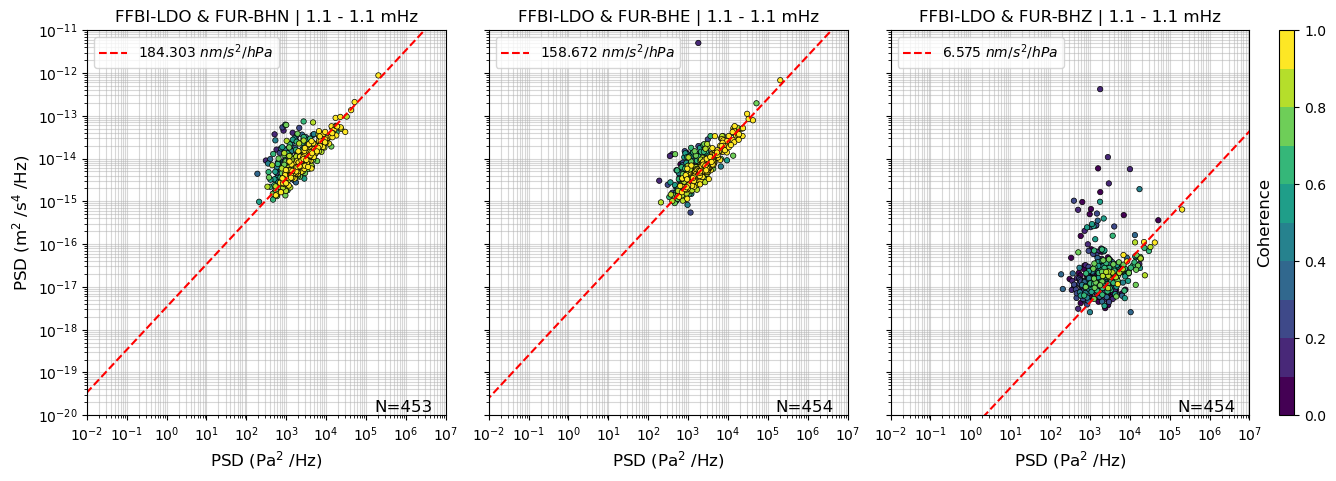

-17.476083929888034 -17.600465613547644 -20.395220298021723



KeyboardInterrupt



In [11]:
import matplotlib.ticker as mticker

f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, faction_of_octave=12, plot=False)

N_bands = dat01.shape[1] - 1

bands = dat01.keys()[1:]

# compliance
compl = pd.DataFrame()
compl['fl'] = f_lower
compl['fu'] = f_upper
compl['fc'] = f_center

complN, complE, complZ = np.ones(N_bands)*np.nan, np.ones(N_bands)*np.nan, np.ones(N_bands)*np.nan

for _n, band in enumerate(bands):


    # if not _n == 13:
    #     continue

    if pd.isnull(dat01.loc[:, band]).all():
        continue

    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]
    _dat3 = dat3.loc[:, ["dates", band]]

    if band < 0.01:
        _dat0 = dat01.loc[:, ["dates", band]]

        name00 = name01

        _coh1 = coh11.loc[:, ["dates", band]]
        _coh2 = coh12.loc[:, ["dates", band]]
        _coh3 = coh13.loc[:, ["dates", band]]
    else:
        _dat0 = dat02.loc[:, ["dates", band]]

        name00 = name02

        _coh1 = coh21.loc[:, ["dates", band]]
        _coh2 = coh22.loc[:, ["dates", band]]
        _coh3 = coh23.loc[:, ["dates", band]]

    # check barometer data
    # print(np.nanmean(_dat0[band][:4]))
    # if np.nanmean(_dat0[band][:4]) > 1e4:
    #     continue

    ##join data frames based on dates and hour
    _df1 = pd.merge(left=_dat0, right=_dat1, how="inner", on="dates")
    _df2 = pd.merge(left=_dat0, right=_dat2, how="inner", on="dates")
    _df3 = pd.merge(left=_dat0, right=_dat3, how="inner", on="dates")

    _df1 = pd.merge(left=_df1, right=_coh1, how="inner", on="dates")
    _df2 = pd.merge(left=_df2, right=_coh2, how="inner", on="dates")
    _df3 = pd.merge(left=_df3, right=_coh3, how="inner", on="dates")

    # remove NaN values
    _df1.dropna(inplace=True)
    _df2.dropna(inplace=True)
    _df3.dropna(inplace=True)

    # remove large values
    _df1 = _df1[_df1.iloc[:, 2] < 1e-11]
    _df2 = _df2[_df2.iloc[:, 2] < 1e-11]
    _df3 = _df3[_df3.iloc[:, 2] < 1e-11]

    # cut time interval
    _df1 = _df1[(_df1.dates > UTCDateTime(t1)) & (_df1.dates < UTCDateTime(t2))]
    _df2 = _df2[(_df2.dates > UTCDateTime(t1)) & (_df2.dates < UTCDateTime(t2))]
    _df3 = _df3[(_df3.dates > UTCDateTime(t1)) & (_df3.dates < UTCDateTime(t2))]

    # reset the index
    _df1 = _df1.reset_index(drop=True)
    _df2 = _df2.reset_index(drop=True)
    _df3 = _df3.reset_index(drop=True)

    # sort for bands
    _df1 = _df1.sort_values(by=band, ascending=True)
    _df2 = _df2.sort_values(by=band, ascending=True)
    _df3 = _df3.sort_values(by=band, ascending=True)

    # remove zeros (they make trouble for the log10)
    _df1 = _df1[~(_df1.iloc[:, :2] == 0).any(axis=1)]
    _df2 = _df2[~(_df2.iloc[:, :2] == 0).any(axis=1)]
    _df3 = _df3[~(_df3.iloc[:, :2] == 0).any(axis=1)]

    # reset the index
    _df1 = _df1.reset_index(drop=True)
    _df2 = _df2.reset_index(drop=True)
    _df3 = _df3.reset_index(drop=True)

    xx1, yy1, ccoh1 = np.log10(_df1.iloc[:, 1]), np.log10(_df1.iloc[:, 2]), _df1.iloc[:, 3]
    xx2, yy2, ccoh2 = np.log10(_df2.iloc[:, 1]), np.log10(_df2.iloc[:, 2]), _df2.iloc[:, 3]
    xx3, yy3, ccoh3 = np.log10(_df3.iloc[:, 1]), np.log10(_df3.iloc[:, 2]), _df3.iloc[:, 3]

#     try:
#         pre1 = __quantile_regression(xx1, yy1, quantiles=[0.01, 0.5, 0.99])
#         pre2 = __quantile_regression(xx2, yy2, quantiles=[0.01, 0.5, 0.99])
#         pre3 = __quantile_regression(xx3, yy3, quantiles=[0.01, 0.5, 0.99])

#     except Exception as e:
#         print(e)
#         pass

    # only select high coherence (=hc)
    coh_thres = 0.8
    df1_hc = _df1_high_coh = _df1[_df1.iloc[:, 3] > coh_thres]
    df2_hc = _df2_high_coh = _df2[_df2.iloc[:, 3] > coh_thres]
    df3_hc = _df3_high_coh = _df3[_df3.iloc[:, 3] > coh_thres]

    xx1_hc, yy1_hc = np.log10(df1_hc.iloc[:, 1]), np.log10(df1_hc.iloc[:, 2])
    xx2_hc, yy2_hc = np.log10(df2_hc.iloc[:, 1]), np.log10(df2_hc.iloc[:, 2])
    xx3_hc, yy3_hc = np.log10(df3_hc.iloc[:, 1]), np.log10(df3_hc.iloc[:, 2])

    # define offest for estimated intercept
    shift_intercept = 0.

    try:
        if len(xx1_hc) >= 10:
            odr1_slope, odr1_inter = __compute_orthogonal_distance_regression(xx1_hc, yy1_hc, xerr=None, yerr=None, bx=None, by=None)
        else:
            odr1_slope, odr1_inter = np.nan, np.nan
        if len(xx2_hc) >= 10:
            odr2_slope, odr2_inter = __compute_orthogonal_distance_regression(xx2_hc, yy2_hc, xerr=None, yerr=None, bx=None, by=None)
        else:
            odr2_slope, odr2_inter = np.nan, np.nan
        if len(xx3_hc) >= 10:
            odr3_slope, odr3_inter = __compute_orthogonal_distance_regression(xx3_hc, yy3_hc, xerr=None, yerr=None, bx=None, by=None)
        else:
            odr3_slope, odr3_inter = np.nan, np.nan
        try:
            complN[_n] = odr1_inter - shift_intercept
        except:
            complN[_n] = np.nan
        try:
            complE[_n] = odr2_inter - shift_intercept
        except:
            complE[_n] = np.nan
        try:
            complZ[_n] = odr3_inter - shift_intercept
        except:
            complZ[_n] = np.nan

        print(odr1_inter, odr2_inter, odr3_inter)

    except Exception as e:
        complN[_n], complE[_n], complZ[_n] = np.nan, np.nan, np.nan
        print(e)
        pass


    ## ____________________________________________________________________

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    cmap = plt.colormaps.get("viridis")
    cmap = plt.get_cmap("viridis", 10)

    plt.subplots_adjust(wspace=0.12)

    ca1 = ax[0].scatter(10**xx1, 10**yy1, s=15, c=ccoh1, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0., vmax=1)
    ca2 = ax[1].scatter(10**xx2, 10**yy2, s=15, c=ccoh2, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0., vmax=1)
    ca3 = ax[2].scatter(10**xx3, 10**yy3, s=15, c=ccoh3, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0., vmax=1)

#     try:
#         ax[0].plot(10**xx1, 10**pre1[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[1].plot(10**xx2, 10**pre2[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[2].plot(10**xx3, 10**pre3[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#     except Exception as e:
#         print(e)
#         pass

    ## add correlation estimate
    # _xx = np.logspace(-10, 10, 100)
    # _yy = 1e-22 * _xx

    # ax[0].plot(_xx, _yy + _xx*1e-17, color="darkred", ls="--", label="1 $m^2/s^4/Pa^2$")
    # ax[1].plot(_xx, _yy + _xx*1e-17, color="darkred", ls="--", label="1 $m^2/s^4/Pa^2$")
    # ax[2].plot(_xx, _yy + _xx*1e-19, color="darkred", ls="--", label="1 $m^2/s^4/Pa^2$")

    try:
        _xx = np.linspace(-10, 10, 100)
        for _i, (slope, intercept) in enumerate(zip([odr1_slope, odr2_slope, odr3_slope], [odr1_inter, odr2_inter, odr3_inter])):

            _intercept = np.sqrt(10**intercept)*1e11
            ax[_i].plot(10**(_xx), 10**(_xx*slope+intercept), color="red", ls="--", label=f"{round(_intercept,3)} $nm/s^2/hPa$")

            # _intercept2 = np.sqrt(10**(intercept-shift_intercept))*1e11
            # ax[_i].plot(10**(_xx), 10**(_xx*slope+(intercept-shift_intercept)), color="purple", ls="--", label=f"{round(_intercept2,3)} $nm/s^2/hPa$")

    except Exception as e:
        print(e)
        pass

    for _i in range(3):
        ax[_i].set_xscale("log")
        ax[_i].set_yscale("logit")
        ax[_i].set_xlim(1e-2, 1e7)
        ax[_i].set_ylim(1e-20, 1e-11)
        ax[_i].grid(zorder=0, alpha=0.5, which="both")
        ax[_i].legend(loc=2)
        ax[_i].set_xlabel(r"PSD (Pa$^2$ /Hz)", fontsize=font)

        ax[_i].xaxis.set_major_locator(mticker.LogLocator(numticks=999))
        ax[_i].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    # ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | fc = {float(_df1.keys()[1][:-2])*1e3} mHz")
    # ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df2.keys()[1][:-2])*1e3} mHz")
    # ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | fc = {float(_df3.keys()[1][:-2])*1e3} mHz")
    ax[0].set_title(f"{name00.replace('_','-')} & {name1.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[1].set_title(f"{name00.replace('_','-')} & {name2.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[2].set_title(f"{name00.replace('_','-')} & {name3.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")

    ax[0].text(.8, .04, f"N={len(xx1)}", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)
    ax[1].text(.8, .04, f"N={len(xx2)}", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)
    ax[2].text(.8, .04, f"N={len(xx3)}", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[0].set_ylabel(r"PSD (m$^2$ /s$^4$ /Hz)", fontsize=font)

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(ca1, cax=cbar_ax)
    cb.set_label("Coherence", fontsize=font, labelpad=-50, color="black")

    plt.show();

    fig.savefig(config['path_to_figs']+f"all/FUR/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz_all.jpg", format="jpg", dpi=150, bbox_inches='tight');
    fig.savefig(config['path_to_figs']+f"all/FUR/gif/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz_all.jpg", format="jpg", dpi=80, bbox_inches='tight');


### Convert

In [ ]:
compl['N'] = np.sqrt(10**(complN))
compl['E'] = np.sqrt(10**(complE))
compl['Z'] = np.sqrt(10**(complZ))

In [ ]:
compl['N'] = np.sqrt(10**complN)*1e9*1e2
compl['E'] = np.sqrt(10**complE)*1e9*1e2
compl['Z'] = np.sqrt(10**complZ)*1e9*1e2

compl.N = np.where(compl.N > 1000, np.nan, compl.N)
compl.E = np.where(compl.E > 1000, np.nan, compl.E)
compl.Z = np.where(compl.Z > 1000, np.nan, compl.Z)

### Store

In [ ]:
compl.to_pickle(config['path_to_data']+"compliance_FUR.pkl")

## Compliance Plot

In [ ]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    scaling = 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 5))

    ax.plot(compl['fc'], compl['Z']*scaling, label="FUR.Z")
    ax.plot(compl['fc'], compl['N']*scaling, label="FUR.N")
    ax.plot(compl['fc'], compl['E']*scaling, label="FUR.E")

    ax.grid(axis="both", ls=":", zorder=0)
    ax.legend(loc=1)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(1e-3, 1e0)

    ax.set_xlabel("Frequency (Hz)", fontsize=font)
    ax.set_ylabel("Compliance (nm/s$^2$/hPa)", fontsize=font)

    plt.show();
    return fig

In [ ]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"FUR_compliance.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
os.system("""spd-say "Finished" """)